In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict 

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util
import ip_routines as ip

import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

sys.path.append(paths.inhouse+'/dif/python')
import dif_utils as du

paths.print_paths()
sys.path.append(paths.inhouse+'/dif/python')

# from Yesh's DIF_IP script
from pixval import Formatter
from enum import IntEnum

green = (0, 255, 0)

Paths defined in paths module:
 paths.ws_dir: /Users/trafferty/workspace
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.mii_home: /Users/trafferty/dev
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.projects_root: /Users/trafferty/data/projects
 paths.images_root: /Users/trafferty/data/images
 paths.inhouse: /Users/trafferty/dev/src/inhouse
 paths.results_root: /Users/trafferty/data/results
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.tmp_dir: /Users/trafferty/tmp
 paths.data_root: /Users/trafferty/data


In [2]:
imgs = OrderedDict()
imgs["+0"  ] = paths.images_root+'/dif/focus/+0/2017-09-29_09.22.41/DispenserOpt_00005_2017-09-29_09.22.52.png'
#imgs["+100"] = paths.images_root+'/dif/focus/+100um/2017-09-29_09.24.18/DispenserOpt_00005_2017-09-29_09.24.30.png'
imgs["+10" ] = paths.images_root+'/dif/focus/+10um/2017-09-29_09.23.27/DispenserOpt_00005_2017-09-29_09.23.38.png'
imgs["+20" ] = paths.images_root+'/dif/focus/+20um/2017-09-29_09.25.05/DispenserOpt_00005_2017-09-29_09.25.15.png'
imgs["+30" ] = paths.images_root+'/dif/focus/+30um/2017-09-29_09.25.38/DispenserOpt_00005_2017-09-29_09.25.49.png'
imgs["+40" ] = paths.images_root+'/dif/focus/+40um/2017-09-29_09.26.13/DispenserOpt_00005_2017-09-29_09.26.24.png'
imgs["-10" ] = paths.images_root+'/dif/focus/-10um/2017-09-29_09.28.59/DispenserOpt_00005_2017-09-29_09.29.09.png'
imgs["-20" ] = paths.images_root+'/dif/focus/-20um/2017-09-29_09.29.44/DispenserOpt_00005_2017-09-29_09.29.54.png'
imgs["-30" ] = paths.images_root+'/dif/focus/-30um/2017-09-29_09.31.29/DispenserOpt_00005_2017-09-29_09.31.39.png'
imgs["-40" ] = paths.images_root+'/dif/focus/-40um/2017-09-29_09.32.16/DispenserOpt_00005_2017-09-29_09.32.27.png'
imgs["+0"  ]

'/Users/trafferty/data/images/dif/focus/+0/2017-09-29_09.22.41/DispenserOpt_00005_2017-09-29_09.22.52.png'

In [14]:
DIF1_ip_config = {
           "rMin": 750,
           "rMax": 1980,
           "pxSize_um": 0.345,
           "nozzSpacing_um": 141.1082,
           "phaseIDs": [1,2,3]
       }

DIF2_ip_config = {
           "rMin": 600,
           "rMax": 2000,
           "pxSize_um": 0.309,
           "nozzSpacing_um": 169.333,
           "phaseIDs": [1]
       }

DIF_Synth_ip_config = {
           "rMin": 500,
           "rMax": 2160,
           "pxSize_um": 0.309,
           "nozzSpacing_um": 131.63,
           "phaseIDs": [1]
}

ip_config = {}

ip_config['timeLapse_us'] = 4    # Time lapse between images for velocity calc
ip_config['pxSize_um'] = 0.345 ;#0.350
# Image crop bounds and sub-sample step size
ip_config['rMin'] = 1028 ;#528 ;#648
ip_config['rMax'] = 2160 ;#2148
ip_config['cMin'] = 0
ip_config['cMax'] = 2560 ;#2548
ip_config['rStep'] = 1
ip_config['cStep'] = 1

# Preprocessing params
ip_config['bg_thresh'] = 30
ip_config['adaptiveMethod'] = cv2.ADAPTIVE_THRESH_GAUSSIAN_C #cv2.ADAPTIVE_THRESH_MEAN_C #cv2.ADAPTIVE_THRESH_GAUSSIAN_C
ip_config['thresholdType'] = cv2.THRESH_BINARY+cv2.THRESH_OTSU#cv2.THRESH_BINARY #cv2.THRESH_BINARY_INV
ip_config['blockSize'] = 25 #odd number like 3,5,7,9,11
ip_config['subConst'] = 2 # constant to be subtracted
ip_config['minThVal'] = 0      # Min and max threshold values
ip_config['maxThVal'] = 255

# Params for pruning blobs by size, circularity
ip_config['circTh'] = 0.7
# Used to filter out images with no drop (hence too many stray objects) and too many drops
ip_config['maxDropsPerImg'] = 200

ip_config["ROI_width_height"] = 150

# Blob registration parameters
ip_config['blobCorrBBXSzPx'] = 101       ;# Correlation bounding box X size (width)
ip_config['blobCorrBBYSzPx'] = 101       ;# Correlation bounding box Y size (height)
ip_config['blobCorrTh'] = 0.95           ;# Blob correlation threshold
ip_config['xDispPxTh'] = 10              ;# Max X displacement in pixels
ip_config['yDispPxTh'] = 150             ;# Max Y displacement in pixels
ip_config['areaDiffTh'] = 100            ;# Max diff in areas of corresponding blobs
ip_config['majorAxisDiffTh'] = 10        ;# Max diff in major axis lengths of corres blobs
ip_config['minorAxisDiffTh'] = 10        ;# Max diff in minor axis lengths of corres blobs

ip_config["minSzInPx"] = 400/(ip_config["rStep"]*ip_config["rStep"])
ip_config["maxSzInPx"] = 1600/(ip_config["rStep"]*ip_config["rStep"])

# Combine the system-specific settings with the defaults (system-specific over-ride defaults)
DIF1_ip_config = {**ip_config, **DIF1_ip_config }
DIF2_ip_config = {**ip_config, **DIF2_ip_config }
DIF_Synth_ip_config = {**ip_config, **DIF_Synth_ip_config }


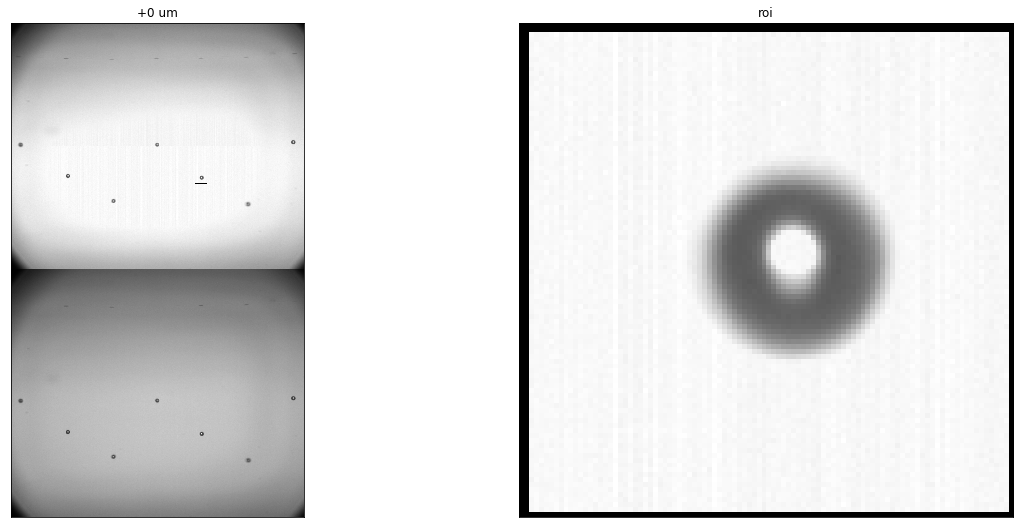

In [15]:
k = "+0"
img16 = cv2.imread(imgs[k],cv2.IMREAD_ANYDEPTH)
img16.dtype
img8 = du.convert16BitTo8Bit(img16)

h,w = 100, 100
sx = 1610
sy = 1310
roi = img16[sy:sy+h, sx:sx+w]  #np slice: [startY:endY, startX:endX]
cv2.rectangle(img16, (sx, sy), (sx+w, sy+h), (0,0,0), 2) # two corners: (startX, startY), (endX, endY)

util.plot_imgs([(du.convert16BitTo8Bit(img16), "%s um" % (k)), (du.convert16BitTo8Bit(roi), "roi")])

In [16]:
k = "+0"

img_path = imgs[k]
metadata_dict = du.getMetadata(imgs[k])
metadata_dict["Nozzle"] = '23'
metadata_dict["PrimaryNozzles"] = "3,0,6"
metadata_dict["SecondaryNozzles"] = "1,2,4,5"
roi_width = 150
ip_config = DIF1_ip_config

debug=True
top, bot = range(2)

im16 = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

primary_nozzles = [int(x) for x in metadata_dict["PrimaryNozzles"].replace(',', ' ').split()]
secondary_nozzles = [int(x) for x in metadata_dict["SecondaryNozzles"].replace(',', ' ').split()]

num_noz_cols = len(primary_nozzles) + len(secondary_nozzles)
nozzle_stats = []

#top_nozzle_col_ROI_lst, bot_nozzle_col_ROI_lst = du.calcNozzleColROIs(im16, metadata_dict, ip_config, debug=debug)
nozzle_col_ROI_set_lst = du.calcNozzleColROIs(im16, metadata_dict, ip_config, debug=debug)

nozzle = int(metadata_dict["Nozzle"])
nozzle_nums = [nozzle-(x-primary_nozzles[0]) for x in range(num_noz_cols)] # fixed math for proper head orientation

for noz_col_idx in range(num_noz_cols):
    nozzle_stat = {}
    nozzle_stat["ROI_set"] = nozzle_col_ROI_set_lst[noz_col_idx]
    nozzle_stat["is_primary"] = (noz_col_idx in primary_nozzles)
    nozzle_stat["NOI"] = True if noz_col_idx == primary_nozzles[0] else False
    nozzle_stat["nozzle"] = nozzle_nums[noz_col_idx]
    nozzle_stat["row"] = int(metadata_dict["Row"])
    
    # place holder for drop data
    nozzle_stat["found_drops"] = False
    nozzle_stat["drop_stats"] = {}
    nozzle_stat["drop_stats"]["drop_top"] = None
    nozzle_stat["drop_stats"]["drop_bot"] = None
    
    nozzle_stats.append(nozzle_stat)


num_cols:  7
coi:  3
col_width:  365


In [17]:
im8 = du.convert16BitTo8Bit(im16)

for idx, nozzle_stat in enumerate(nozzle_stats):
    top_roi = nozzle_stat["ROI_set"][top]
    bot_roi = nozzle_stat["ROI_set"][bot]
    top_drop_roi_img = du.sliceIMG(im8, top_roi)
    bot_drop_roi_img = du.sliceIMG(im8, bot_roi)
    
    found_top, drop_top = du.findDrop(top_drop_roi_img, ip_config, debug)
    if found_top:
        # correct x,y for original image coords
        drop_top.x += top_roi.startX
        drop_top.y += top_roi.startY        
        if debug: print("findDrop: [%d] (%f, %f) Dia=%d" % (idx, drop_top.x, drop_top.y, drop_top.dia))
            
        drop_roi = du.calcDropROI(drop_top, roi_width)
        print(drop_roi)
        drop_roi_img = du.sliceIMG(im16, drop_roi)
        
        #equalize_adapthist(image, kernel_size=None, clip_limit=0.01, nbins=256, **kwargs)
        #drop_roi_img = exposure.equalize_adapthist(drop_roi_img)
        focus_measure_top = du.variance_of_laplacian(drop_roi_img)
        drop_top.stats["focus_measure_top"] = focus_measure_top
        
        found_bot, drop_bot = du.findDrop(bot_drop_roi_img, ip_config, debug)
        if found_bot:
            # correct x,y for original image coords
            drop_bot.x += bot_roi.startX
            drop_bot.y += bot_roi.startY
            
            drop_roi = du.calcDropROI(drop_bot, roi_width)
            drop_roi_img = du.sliceIMG(im16, drop_roi)
            #drop_roi_img = exposure.equalize_adapthist(drop_roi_img)
            focus_measure_bot = du.variance_of_laplacian(drop_roi_img)

    if found_top and found_bot:
        nozzle_stat["found_drops"] = True
        nozzle_stat["drop_stats"]["drop_top"] = drop_top
        nozzle_stat["drop_stats"]["focus_measure_top"] = focus_measure_top + idx
        nozzle_stat["drop_stats"]["drop_bot"] = drop_bot
        nozzle_stat["drop_stats"]["focus_measure_bot"] = focus_measure_bot + (idx*2)
        
        
            
print(nozzle_stats[0])

Bad reference image - 0 drops detected
numGoodBlobsRef: 1
16.755575776860173
RegProp.orientation:  0.16049815807529091
Calculated area:  882.0
findDrop: Stats for 1 of 1:
  (132.078, 593.271), dia: 33.511, area: 882.0000000000000
  RegProp.orientation        : 0.160
  RegProp.eccentricity       : 0.310
  RegProp.equivalent_diameter: 33.511
  RegProp.minor_axis_length  : 37.021
  RegProp.major_axis_length  : 38.941
  RegProp.perimeter          : 161.681
  Calculated area            : 882.000
-----------------------------------------------------
findDrop: [1] (497.078231, 1343.270975) Dia=33
ROI(startY=1268, endY=1418, startX=422, endX=572, cp_x=497, cp_y=1343)
numGoodBlobsRef: 1
16.869174201729876
RegProp.orientation:  0.30699050936840655
Calculated area:  893.9999999999998
findDrop: Stats for 1 of 1:
  (131.491, 668.432), dia: 33.738, area: 893.9999999999998
  RegProp.orientation        : 0.307
  RegProp.eccentricity       : 0.300
  RegProp.equivalent_diameter: 33.738
  RegProp.minor_a

In [18]:
def findBLOBs(img):
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 100;
    params.maxThreshold = 150;

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = .8

    # # Filter by Convexity
    params.filterByConvexity = False
    # params.minConvexity = 0.87

    # # Filter by Inertia
    params.filterByInertia = False
    # params.minInertiaRatio = 0.9

    params.filterByColor = False

    params.filterByArea = True
#     params.minArea = 4 * np.pi
#     params.maxArea = 100 * np.pi
    params.minArea = 20
    params.maxArea = 500

    detector = cv2.SimpleBlobDetector_create(params)
    #detector = cv2.SimpleBlobDetector_create()

    # Detect blobs.
    keypoints = detector.detect(img)
    return keypoints

In [19]:
def findROI(img8, num_cols, coi, tag="", debug=True):
    plot_list = []
    plot_list.append( (img8,'roi:%s'%tag) )
    
    rows,cols = img8.shape
    col_width = int(cols/num_cols)

    h,w = rows, col_width
    sx = int(col_width * coi)
    col_img = img8[0:rows, sx:sx+col_width]  #np slice: [startY:endY, startX:endX]
    #if debug: plot_list.append((col_img, "nozzle on col# %d" %(coi+1)))

    keypoints = findBLOBs(col_img)
    if debug: print( "[findROI] num keypoints found: ", len(keypoints))

    if len(keypoints):
        # Draw detected blobs as red circles.
        # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
        #roi_with_keypoints = cv2.drawKeypoints(roi, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        kp = keypoints[0]
        x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
        if debug: print("[findROI] (%d, %d), dia: %d, area: %f" % (x, y, dia, np.pi*dia))

        roi = col_img.copy()[y-75:y+75, 1:col_width]

        if debug:
#             plot_list.append( (roi,'roi:%s'%tag) )
            cv2.circle(col_img, (x, y), int(dia/2), (0,0,255),2)
            cv2.line(col_img, (x, y-dia), (x, y+dia), (0,0,255), 3)
            cv2.line(col_img, (x-dia, y), (x+dia, y), (0,0,255), 3)
            #plot_list.append( (col_img,'Keypoints') )
        #cv2.rectangle(img8, (sx, sy), (sx+w, sy+h), (0,0,0), 10) # two corners: (startX, startY), (endX, endY)                

    if debug:
        util.plot_imgs(plot_list)
    
    if len(keypoints):
        return roi
    else:
        return None

[findROI] num keypoints found:  2
[findROI] (182, 531), dia: 10, area: 31.415927


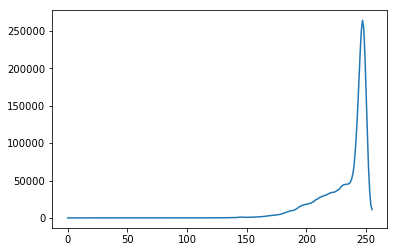

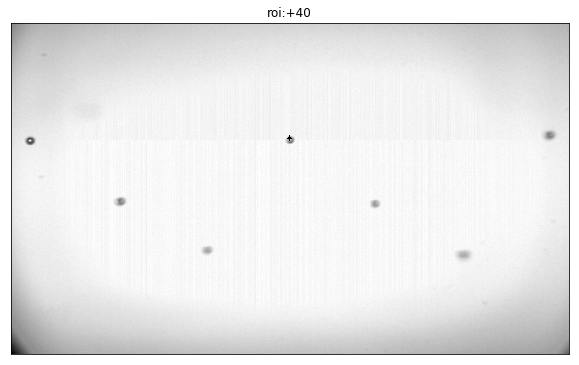

In [20]:
plot_list = []
k = "+40"
img = cv2.imread(imgs[k],cv2.IMREAD_ANYDEPTH)
rows,cols = img.shape
img16 = img[ int(rows/8):int(rows/2)-100, 0:cols  ]

img8 = du.convert16BitTo8Bit(img16)
histr = cv2.calcHist([img8],[0],None,[256],[0,256])
plt.plot(histr)


# plot_list.append((img8, "%s um" % (k)))

num_cols = 7
coi = 3    # 'column of interest', zero-based

roi = findROI(img8, num_cols, coi, tag=k, debug=True)


Finding ROI for img +0
Finding ROI for img +10
Finding ROI for img +20
Finding ROI for img +30
Finding ROI for img +40
Finding ROI for img -10
Finding ROI for img -20
Finding ROI for img -30
Finding ROI for img -40
Found 7 ROIs


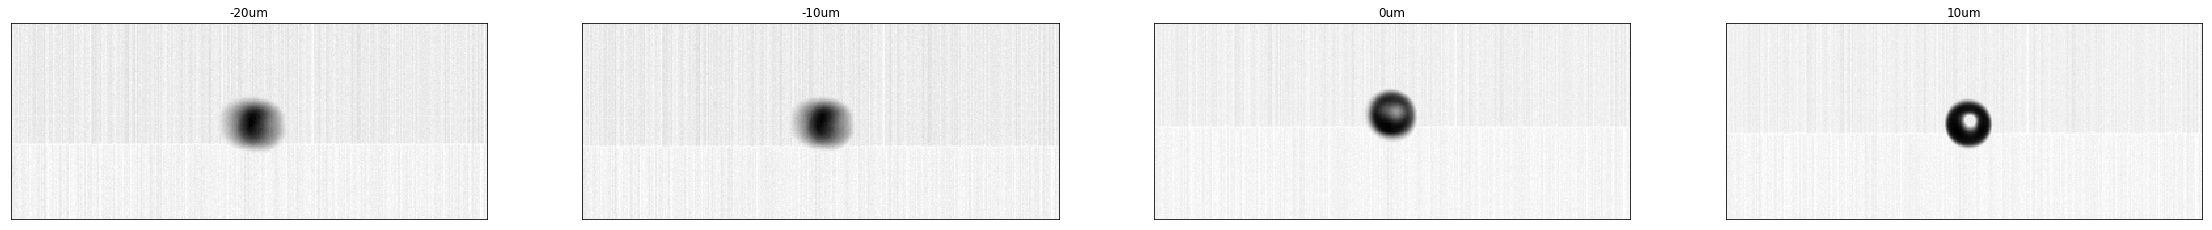

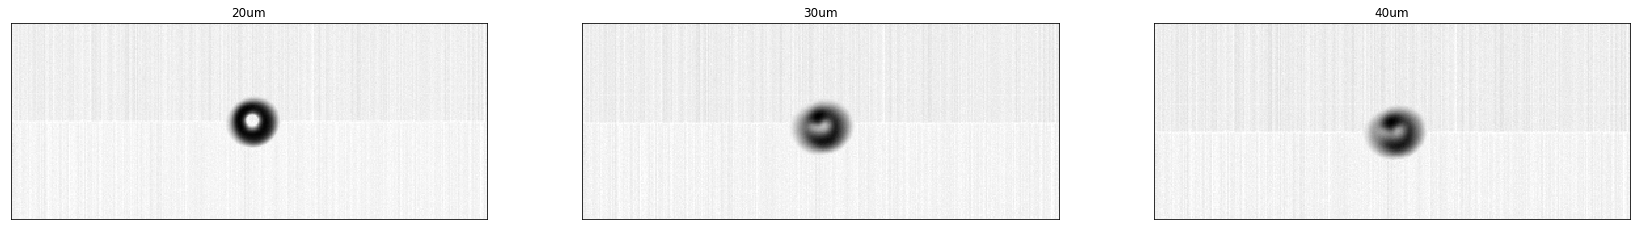

In [21]:
img_list = []
plot_list = []

num_cols = 7
coi = 3   # 'column of interest', zero-based

for k,v in imgs.items():
    print("Finding ROI for img %s" % (k))
    #img16 = cv2.imread(imgs[k],cv2.IMREAD_ANYDEPTH)

    img = cv2.imread(imgs[k],cv2.IMREAD_ANYDEPTH)
    rows,cols = img.shape
    img16 = img[ int(rows/8):int(rows/2)-100, 0:cols  ]
    rows,cols = img16.shape

    img8 = du.convert16BitTo8Bit(img16)
    cv2.putText(img8, k, (50, 50), cv2.FONT_HERSHEY_DUPLEX, 2, (255,255,255), 1)

    roi = findROI(img8, num_cols, coi, tag=k, debug=False)
    if roi is not None:
        img_list.append( (roi, int(k)) )
                
img_list = sorted(img_list, key=lambda x: x[1])

for img in img_list:
    plot_list.append( ( img[0], "%dum" % (int(img[1])) ) )

print("Found %d ROIs" % len(img_list))

util.plot_imgs(plot_list, max_cols = 4)

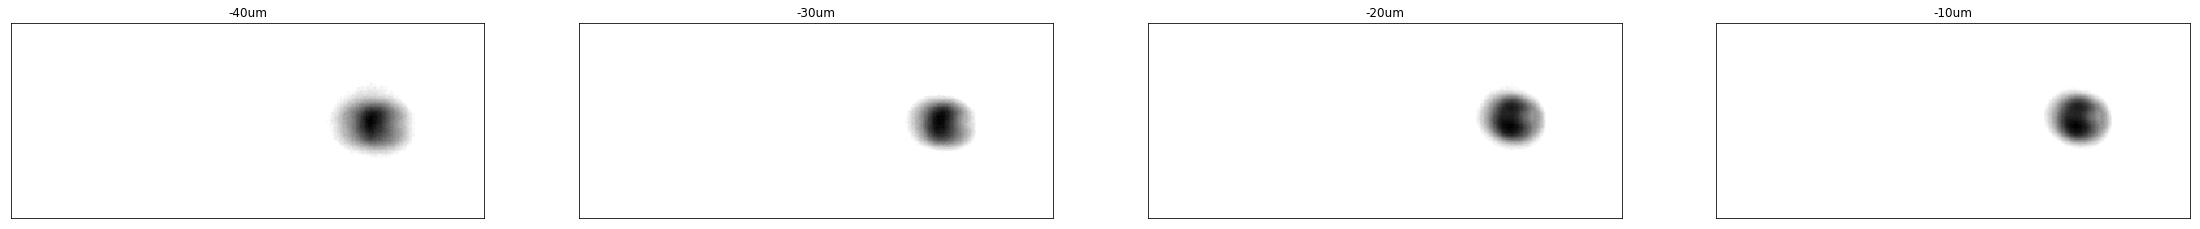

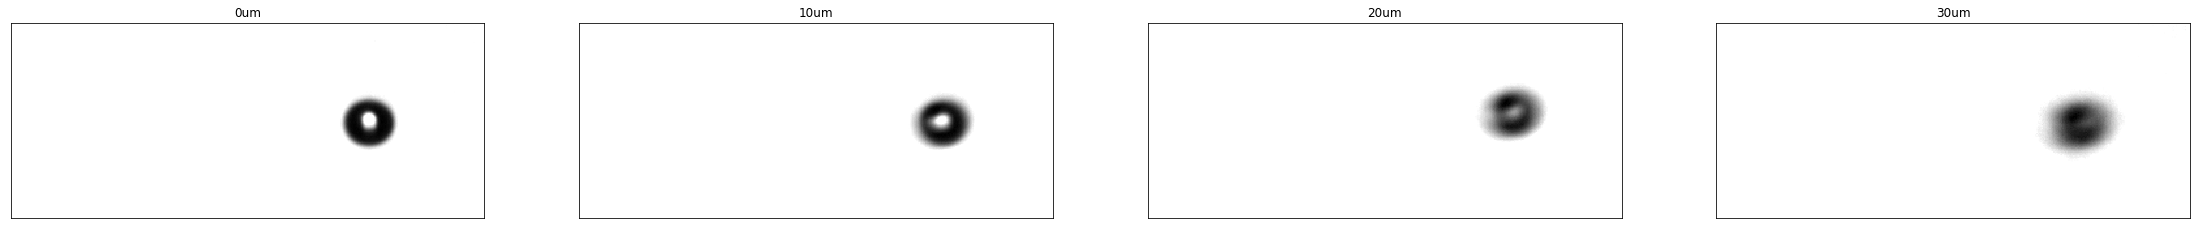

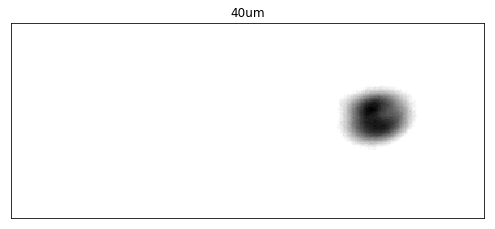

In [15]:
thresh_img_list = []
plot_list = []

for img in img_list:
    ret, roi_thresh = cv2.threshold(img[0], 220, 255, cv2.THRESH_TRUNC) 
    thresh_img_list.append( (roi_thresh, int(img[1])) )
    plot_list.append( ( roi_thresh, "%dum" % (int(img[1])) ) )

thresh_img_list = sorted(thresh_img_list, key=lambda x: x[1])
util.plot_imgs(plot_list, max_cols = 4)

## Test 1: Use the 'variation of the Laplacian' technique

Basically, take the Laplacian (2nd derivitive of image:  highlights regions of an image containing rapid intensity changes) of the image by running the following kernel over entire image:

$\begin{bmatrix}0 & 1 & 0\\1 & -4 & 1\\0 & 1 & 0\end{bmatrix}$

Then, take the variance of the Laplacian.  If an image contains high variance then there is a wide spread of responses, both edge-like and non-edge like, representative of a normal, in-focus image. But if there is very low variance, then there is a tiny spread of responses, indicating there are very little edges in the image. As we know, the more an image is blurred, the less edges there are.



-40um:      31621
-30um:      48841
-20um:      81456
-10um:      89027
 +0um:    1128788
+10um:     479607
+20um:     125315
+30um:      43001
+40um:      40074


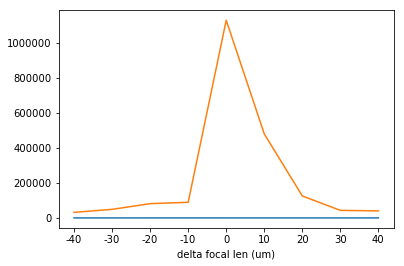

In [16]:
results = []
plot_list = []
ksize=7

# img_list contains list of tuples: (img, 'name')
for img in thresh_img_list:
    # Calc Laplacian of image
    lap_img = cv2.Laplacian(img[0], cv2.CV_64F, ksize=ksize)
    # Cal variance of Laplacian
    focus_measure = lap_img.var()
    plot_list.append( ((lap_img), "%dum: %d" % (img[1], int(focus_measure)) ) )
    results.append( (img[1], int(focus_measure)) )
    print("%+ 3dum: % 10d" % (img[1], int(focus_measure)))

plt.plot(results)
x_labels = [i[0] for i in results]
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel('delta focal len (um)')
plt.show()
#util.plot_imgs(plot_list, max_cols = 2)

In [ ]:

seed_data = {}
seed_data['img_dims'] = (rows, cols, 3)
seed_data['approx_center_yx'] = ( int(rows/2), int(cols/2) )
seed_data['approx_diameter']  = int(np.hypot(rows, cols))
seed_data['diameter_tolerance']  = 0.20
seed_data['found_first']  = False

ellipse, debug_img = ip.findEllipse(img, seed_data, verbose=True, show_plots=True)

if ellipse[0][0] == -99:
    print "\nUnable to find contact area..."
    overlay = fg_img.copy()
else:
    overlay = fg_img.copy()
    approx_area = (np.pi * np.hypot(ellipse[1][0]/2, ellipse[1][1]/2))
    
    cv2.putText(overlay, ("%d"%(approx_area)), (overlay.shape[0]/2-100, overlay.shape[1]/2), cv2.FONT_HERSHEY_DUPLEX, 2, util.green, 3)
    cv2.ellipse(overlay,ellipse,(255,0,0),4) #cv2.ellipse(img, (centerX,centerY), (width,height), 0, 0, 180, color, lt)
    
util.plot_imgs([(img, 'Delta Image'), (debug_img, 'debug: Hough Circles'),(overlay, 'Overlay')], color=False)    

## Test 2: Use Canny, contours and moments to find feature loc, area, then sort based on area


In [ ]:
results = []
plot_list = []
ksize=7

# img_list contains list of tuples: (img, 'name')
for img in thresh_img_list[4:5]:
    # Calc Canny of img
    canny_output = cv2.Canny(img[0], 50, 100, apertureSize=3, L2gradient=True)
    #canny_output = cv2.Canny(img[0], 250, 255, apertureSize=3, L2gradient=True)
    
    
    # #     sobelX = cv2.Sobel(img[0],cv2.CV_64F, 1, 0, ksize=3)
    # #     sobelX = np.uint8(np.absolute(sobelX))
    # #     sobelY = cv2.Sobel(img[0],cv2.CV_64F, 0, 1, ksize=3)
    # #     sobelY = np.uint8(np.absolute(sobelY))
    # #     sobelCombined = cv2.bitwise_or(sobelX, sobelY)

    plot_list.append( (canny_output,"%dum" % (img[1])) )
    #continue
    
    # Find contours
    contour_img, contours, hierarchy = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Get the moments
    mu_lst = []
    for contour in contours:
        mu = cv2.moments(contour, False)
        mu_lst.append(mu)

    #vector<Point2f> mc( contours.size() );
    mc_lst = []
    for i, contour in enumerate(contours):
        mu = mu_lst[i]
        mc = ( (mu['m10']/mu['m00']), (mu['m01']/mu['m00']) )
        print( mc)
        mc_lst.append(mc)

    # Draw contours
    #Mat drawing = Mat::zeros( canny_output.size(), CV_8UC3 );
    rows,cols = img[0].shape
    drawing  = np.zeros((rows, cols, 3), np.uint8)
    for i, contour in enumerate(contours):
        cv2.drawContours( drawing, contours, i, (128,255,255), 3, cv2.LINE_AA, hierarchy, 0 )
        cp = (int(mc_lst[i][0]), int(mc_lst[i][1]) )
        cv2.circle(drawing, cp, 4, (255,0,0),4)    

    if len(contours) > 0:
        #Calculate the area with the moments 00 and compare with the result of the OpenCV function
        print("Info: Area and Contour Length");
        for i, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            arc_length = cv2.arcLength( contour, True )
            print(" * Contour[%d] - Area (M_00) = %.2f - Area OpenCV: %.2f - Length: %.2f" % (i, mu_lst[i]['m00'], area, arc_length) )

        plot_list.append( (drawing,"%dum: %d" % (img[1], int(area))) )
        results.append( (img[1], int(area)) )
        print("%dum: %d" % (img[1], int(area)))
    else:
        print("No contours found for %dum" % (img[1]) )

plt.plot(results)
x_labels = [i[0] for i in results]
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel('delta focal len (um)')
plt.show()
util.plot_imgs(plot_list, max_cols = 2)

In [ ]:
plot_list = []

for img in thresh_img_list[2:6]:
    cimg = img[0].copy()

    method = cv2.HOUGH_GRADIENT
    dp = 1           # inverse ratio of resolution
    min_dist = 5    # minimum distance between detected centers
    param1 = 100      # upper threshold for the internal Canny edge detector
    param2 = 30      # threshold for center detection.
    minRadius = 8
    maxRadius = 30

    circles = cv2.HoughCircles(img[0],cv2.HOUGH_GRADIENT, dp, min_dist,
                               param1=param1, param2=param2, 
                               minRadius=minRadius, maxRadius=maxRadius)


    if circles is not None:
        plot_list.append( (img[0],"%dum" % (img[1])) )
        plot_list.append( (cimg,"%dum found" % (img[1])) )

        numFound = len(circles[0,:])
        print(" num circles found (%dum): %d" % (img[1], numFound))

        for i in circles[0,:]:
            # draw the outer circle
            print("  radius = %d" % (i[2]))
            cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),1)
            # draw the center of the circle
            cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),1)

#     # convert the (x, y) coordinates and radius of the circles to integers
#     #circles = np.uint16(np.around(circles, 0))
#     circles = np.round(circles[0, :]).astype("int")

#     def getKey(item):
#         return item[2]
#     circles = sorted(circles, key=getKey)  # sort circles based on radius (item[2])

#     pt_clusters=[ []  for x in range(7) ]
#     pt_averages=[ ]

util.plot_imgs(plot_list, max_cols = 2)

### Debugging the images from DIF whith BLOB failures

In [5]:
import glob
import os.path
from ipywidgets import interact

In [6]:
folder_root = paths.tmp_dir + "/DIF/dif_images/focus/auto_focus_mishaps"

glob_filespec = "%s/nozCol_*.png" % (folder_root)

img_paths = glob.glob(glob_filespec)
img_files = [os.path.basename(path) for path in img_paths ]

len(img_paths)

fname=os.path.splitext( img_files[0])[0]
print(fname)
_,nozNum,colNum,focus,PDdelay = fname.split('_')
print(focus)

# nozCol_7_3_-10_40

nozCol_20_3_-25_80
-25


Processing file:  /Users/trafferty/tmp/DIF/dif_images/focus/auto_focus_mishaps/nozCol_20_3_-25_80.png
X: min idx: 259, max idx: 292
Y: min idx: 987, max idx: 1019
Drop: (275, 1003)


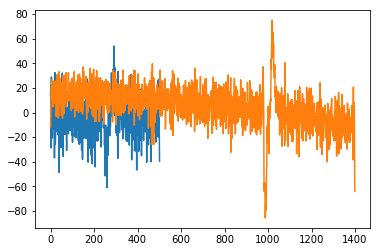

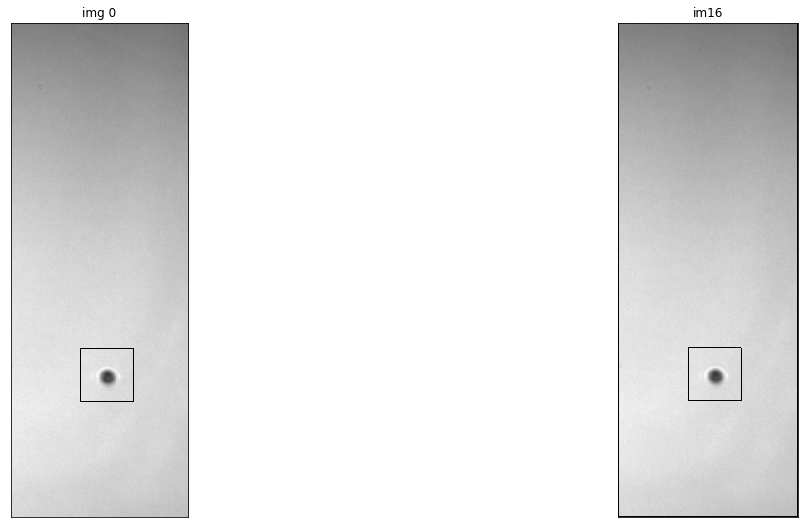

In [69]:
idx = 0

img_path = img_paths[idx]
print("Processing file: ", img_path)
im16 = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
rows,cols = im16.shape

#util.plot_imgs([(im16, 'img %d'%idx)], max_cols = 2)

crop = 5
roi = du.ROI(startY=crop, endY=rows-crop, startX=crop, endX=cols-crop)
drop_roi_img = im16[crop:rows-crop, crop:cols-crop] #np slice: [startY:endY, startX:endX]

p_x = drop_roi_img.mean(axis=0)
p_x_grad = np.gradient(p_x)
plt.plot(p_x_grad)
max_idx = np.argmax(p_x_grad)
min_idx = np.argmin(p_x_grad)
print("X: min idx: %d, max idx: %d" % (min_idx, max_idx))
x = min_idx + int(0.5 * (max_idx - min_idx))

p_y = drop_roi_img.mean(axis=1)
p_y_grad = np.gradient(p_y)
plt.plot(p_y_grad)
max_idx = np.argmax(p_y_grad)
min_idx = np.argmin(p_y_grad)
print("Y: min idx: %d, max idx: %d" % (min_idx, max_idx))
y = min_idx + int(0.5 * (max_idx - min_idx))

print("Drop: (%d, %d)" % (x,y))

cv2.rectangle(im16, (x-75, y-75), (x+75, y+75), (0,0,0), 2) # two corners: (startX, startY), (endX, endY)

plt.figure()
util.plot_imgs([(drop_roi_img, 'img %d'%idx), (im16, 'im16')], max_cols = 2)


In [34]:
def processNozCol(im8, debug):
    rows,cols = im8.shape

    roi = du.ROI(startY=1, endY=rows, startX=1, endX=cols)

    drop_roi_img = du.sliceIMG(im8, roi)

    if False:
        found, drop = du.findDrop(drop_roi_img, ip_config, debug)
    else:
        keypoints = findBLOBs(drop_roi_img)
        if debug: print( "[findROI] num keypoints found: ", len(keypoints))

        if len(keypoints):
            kp = keypoints[0]
            x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
            if debug: print("[findROI] (%d, %d), dia: %d, area: %f" % (x, y, dia, np.pi*dia))

            drop = du.Drop(x = x, y = y, dia=dia )
            found = True
        else:
            found = False
    
    if found:
        # correct x,y for original image coords
        drop.x += roi.startX
        drop.y += roi.startY        
        if debug: print("findDrop: [%d] (%f, %f) Dia=%d" % (idx, drop.x, drop.y, drop.dia))

        drop_roi = du.calcDropROI(drop, roi_width)
        #print(drop_roi)
        drop_roi_img = du.sliceIMG(im16, drop_roi)

        #equalize_adapthist(image, kernel_size=None, clip_limit=0.01, nbins=256, **kwargs)
        #drop_roi_img = exposure.equalize_adapthist(drop_roi_img)
        focus_measure = du.variance_of_laplacian(drop_roi_img)

    else:
        if debug: print("findDrop: Failed!")
        #drop_roi_img = np.ndarray(shape=(roi_width,roi_width), dtype=np.int8)
        drop_roi_img = None
        focus_measure_top = 0

    return found_top, focus_measure, drop_roi


    
    

In [36]:
image_set = []
for idx, img_path in enumerate(img_paths[0:5]):
    img_path = img_paths[idx]
    im16 = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    im8 = du.convert16BitTo8Bit(im16)

    found_top, focus_measure_top, drop_roi = processNozCol(im8, True)
    
    if found_top:
#         plt.figure()
#         plt.imshow(drop_roi_img,cmap='gray')
#         plt.show()
        fname = os.path.splitext(os.path.basename(img_path))[0]
    
        #drop_roi_img = du.sliceIMG(im16, drop_roi)
        drop_roi.startX
        
        cv2.rectangle(im16, (drop_roi.startX, drop_roi.startY), (drop_roi.startX+roi_width, drop_roi.startY+roi_width), (0,0,0), 2) # two corners: (startX, startY), (endX, endY)

        cv2.putText(im16, "%.1f" % focus_measure_top, (1, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

        image_set.append( (im16, fname) )
    else:
        image_set.append( (np.empty([roi_width, roi_width]), fname) )

len(image_set)


[findROI] num keypoints found:  0
findDrop: Failed!


UnboundLocalError: local variable 'focus_measure' referenced before assignment

In [12]:
def browse_images(image_set):
    n = len(image_set)
    def view_image(i):
        #plt.imshow(images[i][0], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.figure(figsize = (40,15))
        plt.imshow(image_set[i][0], cmap='gray',interpolation='nearest', aspect='equal')
        plt.title(image_set[i][1])
        plt.show()
    interact(view_image, i=(0,n-1))

In [13]:
browse_images(image_set)

interactive(children=(IntSlider(value=29, description='i', max=59), Output()), _dom_classes=('widget-interact'…